In [ ]:
import os.path
import traceback
from glob import glob
from typing import Tuple
import numpy as np
import mdtraj as md
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.optimize import NonlinearConstraint, minimize
from scipy.special import logsumexp, softmax
from tqdm import tqdm
from peptonebench.filter_unphysical_samples import _get_physical_traj_indices
import math 
output_path = './SAXS_analyses/'

# find if existing numpy files exist (i.e., this one has been run and saved)
def find_npy_filenames(path_to_dir, suffix=".npy"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

def find_fasta_filenames(path_to_dir, suffix=".fasta"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]


UNCERTAINTY_FACTOR = 1.0

def get_weights(
    lmbd: np.ndarray,  # shape (n_alphas, n_obs)
    std_delta_cs: np.ndarray,  # shape (n_obs, n_samples)
):  # shape (n_alphas, n_samples)
    """Get normalized weights from lambda. Samples with any NaN cs will have weight 0."""
    mask_nan = ~np.isnan(std_delta_cs).any(axis=0)
    is_flat = False
    if len(lmbd.shape) == 1:
        is_flat = True
        lmbd = lmbd.reshape(1, -1)
    weights = np.zeros((lmbd.shape[0], std_delta_cs.shape[1]))
    weights[:, mask_nan] = softmax(-np.dot(lmbd, std_delta_cs[:, mask_nan]), axis=-1)
    if is_flat:
        weights = weights.flatten()
    return weights

def get_ESS(weights: np.ndarray) -> float:
    """Kish effective sample size."""
    mask_nan = ~np.isnan(weights)
    if not mask_nan.any():
        return np.nan
    norm = np.sum(weights[mask_nan])  # should be 1
    return norm**2 / np.dot(weights[mask_nan], weights[mask_nan])

def get_RMSE(
    std_delta_cs: np.ndarray,  # shape (n_obs, n_samples)
    weights: np.ndarray = None,  # shape (n_samples,)
    order: int = 2,  # order of the norm
) -> float:
    """Root Mean Square Error."""
    assert len(std_delta_cs.shape) == 2
    mask_nan = ~np.isnan(std_delta_cs).any(axis=0)
    if weights is None:
        return np.linalg.norm(np.average(std_delta_cs[:, mask_nan], axis=1), ord=order) / np.power(
            len(std_delta_cs),
            1 / order,
        )
    mask_nan_weights = ~np.isnan(weights)
    if weights[mask_nan_weights & (~mask_nan)].sum() != 0:
        print("+++ WARNING: samples with NaN chemical shifts should have 0 weight")
    mask_nan = mask_nan & mask_nan_weights
    if not mask_nan.any():  # this happens if the optimization failed
        return np.nan
    return np.linalg.norm(
        np.average(std_delta_cs[:, mask_nan], weights=weights[mask_nan], axis=1),
        ord=order,
    ) / np.power(len(std_delta_cs), 1 / order)

def parse_gensaxs_dat(filename: str):

    df = pd.read_csv(filename)
    # drop index column
    df = df.drop(columns=["Unnamed: 0"])
    q = np.array(df.columns).astype(float) # shape (n_obs, )
    I_gen = np.array(df) # shape (n_samples, n_obs)

    return q, I_gen

def parse_saxs_dat(filename: str):
    assert filename.endswith(".dat"), "Input file should be a .dat file"
    
    expt_df = pd.read_csv(
        filename,
        sep="\s+",
        header=None,
        names=["q", "I(q)", "sigma"],
        usecols=[0, 1, 2],
        on_bad_lines="skip",
        encoding="latin1",  
    )
    expt_df = expt_df.apply(pd.to_numeric, errors="coerce").dropna()
    if len(expt_df) == 0:
        raise pd.errors.ParserError

    return expt_df

def get_intensity_scaling(
    I_exp: np.ndarray,  # shape (n_obs,)
    sigma_exp: np.ndarray,  # shape (n_obs,)
    I_gen: np.ndarray,  # shape (n_samples, n_obs)
) -> np.ndarray:
    """According to Svergun et al. (1995)"""
    assert I_exp.shape[0] == sigma_exp.shape[0]
    if len(I_gen.shape) == 1:
        I_gen = I_gen.reshape(1, -1)
    assert I_exp.shape[0] == I_gen.shape[1]
    return (np.sum(I_exp * I_gen / sigma_exp**2, axis=1) / np.sum((I_gen / sigma_exp) ** 2, axis=1)).reshape(-1, 1)

def get_std_delta_saxs(
    I_exp: np.ndarray,  # shape (n_obs,)
    sigma_exp: np.ndarray,  # shape (n_obs,)
    I_gen: np.ndarray,  # shape (n_samples, n_obs)
    intensity_scaling: bool = True,
) -> np.ndarray:  # shape (n_obs, n_samples)
    c = get_intensity_scaling(I_exp, sigma_exp, I_gen) if intensity_scaling else 1.0
    return ((c * I_gen - I_exp) / sigma_exp).T

def get_std_delta_saxs_w(
    I_exp: np.ndarray,  # shape (n_obs,)
    sigma_exp: np.ndarray,  # shape (n_obs,)
    I_gen: np.ndarray,  # shape (n_samples, n_obs)
    weights: np.ndarray = None,  # shape (n_samples,)
) -> np.ndarray:  # shape (n_obs, 1)
    av_I_gen = np.average(I_gen, axis=0, weights=weights)
    c = np.sum(I_exp * av_I_gen / sigma_exp**2) / np.sum((av_I_gen / sigma_exp) ** 2)
    return ((c * av_I_gen - I_exp) / sigma_exp).reshape(-1, 1)

def loss(
    logw: np.ndarray,  # shape (n_samples,)
    alpha: float,
    I_exp: np.ndarray,  # shape (n_obs,)
    sigma_exp: np.ndarray,  # shape (n_obs,)
    I_gen: np.ndarray,  # shape (n_samples, n_obs)
) -> float:
    log_weights = logw - logsumexp(logw)
    weights = np.exp(log_weights)

    av_I_gen = weights @ I_gen
    inv_sigma2 = np.power(sigma_exp, -2)
    c = np.sum(I_exp * av_I_gen * inv_sigma2) / np.sum(inv_sigma2 * av_I_gen**2)
    delta = c * av_I_gen - I_exp

    # loss: 0.5 chi_square - alpha * entropy(weights)
    loss = 0.5 * np.sum(np.square(delta) * inv_sigma2) + alpha * np.sum(weights * log_weights)

    d_loss_d_weights_chi2 = 0.5 * I_gen @ (2 * c * delta * inv_sigma2)
    d_loss_d_weights_entropy = alpha * (log_weights + 1)
    d_loss_d_weights = d_loss_d_weights_chi2 + d_loss_d_weights_entropy
    jac = weights * d_loss_d_weights - weights * (weights @ d_loss_d_weights)

    return loss, jac - weights * np.sum(jac)  # adjusted for logsumexp shift

def run_loss_minimization(
    alpha_range: np.ndarray,
    I_exp: np.ndarray,  # shape (n_obs,)
    sigma_exp: np.ndarray,  # shape (n_obs,)
    I_gen: np.ndarray,  # shape (n_samples, n_obs)
) -> np.ndarray:
    n_samples = I_gen.shape[0]

    def loss_wrapper(alpha: float) -> np.ndarray:
        res = minimize(
            fun=lambda x: loss(x, alpha, I_exp, sigma_exp, I_gen),
            x0=np.log(np.ones(n_samples) / n_samples),
            # constraints=NonlinearConstraint(logsumexp, 0, 0, jac=softmax), # not really needed
            method="trust-constr",
            options={"maxiter": 5000},
            jac=True,
        )
        if not res.success:
            print(f"+++ WARNING: alpha={alpha:e}, failed: {res.message}")
            return np.full(n_samples, np.nan)
        return softmax(res.x)

    return np.array([loss_wrapper(alpha) for alpha in alpha_range])
    

def gamma(
    lmbd: np.ndarray,  # shape (n_obs,)
    alpha: float,
    std_delta_saxs: np.ndarray,  # shape (n_obs, n_samples)
    rebalance: float = 1.0,
) -> Tuple[float, np.ndarray]:  # gamma, jac
    """Return the reweighting loss function."""
    logw = -np.dot(lmbd, std_delta_saxs)
    gamma = logsumexp(logw) + 0.5 * alpha * np.dot(lmbd, lmbd)
    jac = -np.dot(std_delta_saxs, softmax(logw)) + alpha * lmbd

    return gamma * rebalance, jac * rebalance


def run_gamma_minimization(alpha_range: np.ndarray, std_delta_saxs: np.ndarray) -> np.ndarray:
    """Run the minimization for a given alpha. Any sample containing NaN cs will be ignored."""
    mask_nan = ~np.isnan(std_delta_saxs).any(axis=0)

    def gamma_wrapper(alpha: float) -> np.ndarray:  # shape (n_obs,)
        """Run the minimization for a given alpha."""
        res = minimize(
            lambda x: gamma(x, alpha, std_delta_saxs[:, mask_nan], min(1, 1 / alpha)),
            np.random.rand(len(std_delta_saxs)),
            jac=True,
        )
        if not res.success:
            print(f"+++ WARNING: alpha={alpha:e}, failed: {res.message}")
            return np.full_like(res.x, np.nan)
        return res.x

    return np.array([gamma_wrapper(alpha) for alpha in alpha_range])
    
def saxs_reweight(
    generator_dir: str,
    protein: str,
    gen_saxs_data: str,
    saxs_data: str,
    n_alphas: int = 64,
    ess_abs_threshold: float = 100,
    ess_rel_threshold: float = 0.1,
    # skip_consistency_check: bool = False,
    filter_unphysical_traj: bool = False,
    lagrange_fit: bool = False
):
    
    # get generated and experimental saxs data
    q, I_gen = parse_gensaxs_dat(gen_saxs_data)
    exp = parse_saxs_dat(saxs_data)
    I_exp = np.array(exp['I(q)'])
    sigma_exp = np.array(exp['sigma'])
    
    alpha_range = np.flip(10 ** np.linspace(-2, 8, n_alphas))

    try:
        if lagrange_fit:
            std_delta_saxs = get_std_delta_saxs(I_exp, sigma_exp, I_gen, intensity_scaling=True)
            if len(std_delta_saxs) == 0:
                raise ValueError(f"no data found for {generator_dir}: this should never happen")
            n_obs_i = std_delta_saxs.shape[0]
            n_samples_i = std_delta_saxs.shape[1]
        else:
            n_samples_i = len(I_gen)
            n_obs_i = len(I_exp)
        
        if filter_unphysical_traj:

            trj_stemfile = os.path.join(generator_dir+protein)
            if os.path.exists(trj_stemfile + ".xtc"):
                trj = md.load(trj_stemfile + ".xtc", top=trj_stemfile + ".pdb")
            elif os.path.exists(trj_stemfile + ".pdb"):
                trj = md.load(trj_stemfile + ".pdb")
            else:
                raise FileNotFoundError(f"trajectory file not found for {protein} in {generator_dir}")
            assert len(trj) == n_samples_i, "trajectory length does not match number of calulcated SAXS intensity samples"
            valid_samples = filter_unphysical_traj._get_physical_traj_indices(trj)
            print(f"--- filtered {protein} from {len(trj)} to {len(valid_samples)} samples")
            if len(valid_samples) == 0:
                print(f"+++ WARNING: no valid samples after filtering for {protein}")
            weights = np.full((len(alpha_range), n_samples_i), np.nan)
            if lagrange_fit:
                opt_lmbd = run_gamma_minimization(alpha_range, std_delta_saxs[:, valid_samples])
                weights[:, valid_samples] = get_weights(opt_lmbd, std_delta_saxs[:, valid_samples])
            else:
                weights[:, valid_samples] = run_loss_minimization(
                    alpha_range,
                    I_exp,
                    sigma_exp,
                    I_gen[valid_samples, :],
                )
        else:
            if lagrange_fit:
                opt_lmbd = run_gamma_minimization(alpha_range, std_delta_saxs)
                weights = get_weights(opt_lmbd, std_delta_saxs)
            else:
                weights = run_loss_minimization(alpha_range, I_exp, sigma_exp, I_gen)
        if np.isnan(weights).all():
            print(f"+++ WARNING: minimization failed for all alphas for {protein}")
        if lagrange_fit:
            rew_RMSEs = np.array([get_RMSE(std_delta_saxs, w) for w in weights])
            plain_rmse_i = get_RMSE(std_delta_saxs[:, valid_samples]) # for prior exclude unphysical structures
        else:
            rew_RMSEs = np.array([get_RMSE(get_std_delta_saxs_w(I_exp, sigma_exp, I_gen, w)) for w in weights])
            plain_rmse_i = get_RMSE(get_std_delta_saxs_w(I_exp, sigma_exp, I_gen))
        ESSs = np.array([get_ESS(w) for w in weights])
        ess_threshold = min(np.nanmax(ESSs), max(ess_abs_threshold, ess_rel_threshold * n_samples_i))
        sel = np.arange(len(ESSs))[ESSs >= ess_threshold][-1]

        n_obs = len(q)
        n_samples = len(valid_samples)
        sel_alpha = alpha_range[sel]
        sel_rmse = rew_RMSEs[sel]
        plain_rmse = get_RMSE(std_delta_saxs[:, valid_samples]) # for prior exclude unphysical structures
        sel_ess = ESSs[sel]
        sel_weights = weights[sel]

        # save data
        resdict = {}
        resdict['n_obs']= n_obs
        resdict['n_samples']= n_samples
        resdict['prior_rmse']= plain_rmse
        resdict['alpha']= sel_alpha
        resdict['post_rmse']= sel_rmse
        resdict['ess']= sel_ess
        resdict['weights']= sel_weights
        resdict['all_alphas']= alpha_range
        resdict['all_post_rmse']= rew_RMSEs
        resdict['all_ess']= ESSs
        resdict['all_weights']= weights
        
        return resdict
        
    except Exception:
        print(f"--- skipping {protein}: {traceback.format_exc()}")



In [ ]:
#####################
### EXAMPLE USAGE ###
#####################

### MAKE SURE TO REPLACE THE PATHS WITH YOUR PATHS

model = 'idp-o'
protein = 'FLN5A3A3'

predfile = f'../processed_predictions/{model}/pepsisaxs_{protein}/saxs_curves.csv'
expfile = f'../EXP_DATA/{protein}/SAXS_bift.dat'
ensemble_path = f'../processed_predictions/{model}/'

resdict = saxs_reweight(generator_dir=ensemble_path, protein=protein, gen_saxs_data = predfile, saxs_data = expfile, n_alphas=3, filter_unphysical_traj=True, lagrange_fit=True)
resdict

# Sanity check - sum of valid sample weights = 1.0
#mask_nan_weights = ~np.isnan(resdict['weights'])
#np.sum(resdict['weights'][mask_nan_weights])

--- filtered FLN5A3A3 from 1000 to 1000 samples


{'n_obs': 2550,
 'n_samples': 1000,
 'prior_rmse': 1.1463728153467636,
 'alpha': 1000.0,
 'post_rmse': 1.0482933069909828,
 'ess': 878.2768210214812,
 'weights': array([0.00138897, 0.00125067, 0.00115552, 0.00123742, 0.00162533,
        0.00093519, 0.00073098, 0.00080662, 0.00081271, 0.00100915,
        0.00097211, 0.00061912, 0.00090949, 0.00124916, 0.00074656,
        0.00063385, 0.00147389, 0.00030079, 0.00058712, 0.00039843,
        0.00143589, 0.001146  , 0.00090815, 0.00060156, 0.00119092,
        0.00058654, 0.00114756, 0.00102239, 0.00115631, 0.00116023,
        0.0007001 , 0.00095283, 0.00069721, 0.0011064 , 0.00115401,
        0.00123708, 0.00103144, 0.00072278, 0.00122018, 0.00097834,
        0.00118365, 0.00130503, 0.0003763 , 0.00141813, 0.00167861,
        0.00133751, 0.00122612, 0.00074044, 0.00087213, 0.00036445,
        0.00054292, 0.00090726, 0.00124832, 0.00153192, 0.00130323,
        0.00099823, 0.00027572, 0.00184877, 0.00044243, 0.0014713 ,
        0.00101708, 0.0

In [14]:
resdict['all_ess']

array([999.99997374, 878.30169374,   5.49083244])

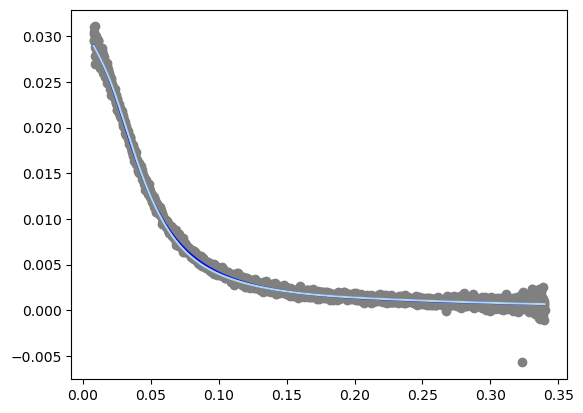

In [15]:
# check reweighted result
exp = parse_saxs_dat(expfile)
q, I_gen = parse_gensaxs_dat(predfile)
I_exp = np.array(exp['I(q)'])
sigma_exp = np.array(exp['sigma'])
s = get_intensity_scaling(I_exp, sigma_exp, I_gen)
wopt = np.nan_to_num(resdict['weights'], nan=0)

#plt.errorbar(q, I_exp, sigma_exp, color = 'grey')
plt.scatter(q, I_exp, color = 'grey')
plt.plot(q, np.average(I_gen, axis=0, weights=wopt), color = 'blue')
plt.plot(q, np.average(I_gen, axis=0), color = 'lightblue')
#plt.yscale('log')

In [ ]:
# Run analysis for all predictors and proteins (checking if analysis already run and skipping those in that case)

models = ['alphafold', 'bioemu',  'boltz2',  'esmflow',  'esmfold',  'idpgan',  'idp-o', 'peptron_cfm_pdb_idrome_20250525_606720', 'peptron_stable_pdb_20250809_236800'] 

# === CONFIG ===
### MAKE SURE TO REPLACE THE PATHS WITH YOUR PATHS

fasta_dir = '../predictions/fasta/'
ensemble_root = '../processed_predictions/' # here are the heavy atom trajectories for all models (use this for physical filtering)
proton_root = '../protonated_predictions/'  # this is where the protonated pdb files
output_root = './'  
exp_root = '../EXP_DATA/'

# === Load protein list ===
files = find_fasta_filenames(fasta_dir)
proteins = [f[:-6] for f in files]
#print(f"Proteins: {proteins}")

# check for which of these proteins there are chemical shift data
SAXSproteins = []
for protein in proteins:
    if os.path.exists(exp_root+f"{protein}/SAXS_bift.dat"):
        SAXSproteins.append(protein)

# Iterature through all models and proteins and perform analysis
for model in models:
    for protein in SAXSproteins:

        print(f"Running {protein} predicted by {model}...")

        # check if output file already exists
        if os.path.exists(proton_root+f"{model}/{protein}/SAXSrew.npy"):
            print("Output file already exists, skipping this...")
            continue
        else:
            predfile = ensemble_root + f"{model}/pepsisaxs_{protein}/saxs_curves.csv"
            expfile = exp_root + f"{protein}/SAXS_bift.dat"
            ensemble_path = ensemble_root + f"{model}/"

            if not os.path.exists(predfile):
                print(f"Skipping {model}/{protein} due to missing SAXS predictions...")
                continue

            resdict = saxs_reweight(generator_dir=ensemble_path, protein=protein, gen_saxs_data = predfile, saxs_data = expfile, n_alphas=64, filter_unphysical_traj=True, lagrange_fit=True)
            
            # save data
            np.save(proton_root + f"{model}/{protein}/SAXSrew.npy", resdict)

print('Done!')

Running PaaA2 predicted by bioemu...
Output file already exists, skipping this...
Running DSS1 predicted by bioemu...
Output file already exists, skipping this...
Running p15PAF predicted by bioemu...
Output file already exists, skipping this...
Running A1 predicted by bioemu...
Output file already exists, skipping this...
Running ProTa predicted by bioemu...
Output file already exists, skipping this...
Running BecN predicted by bioemu...
Output file already exists, skipping this...
Running RS predicted by bioemu...
Output file already exists, skipping this...
Running GHR-ICD predicted by bioemu...
Output file already exists, skipping this...
Running aSyn predicted by bioemu...
Output file already exists, skipping this...
Running Ash1 predicted by bioemu...
Output file already exists, skipping this...
Running ERNTD predicted by bioemu...
Output file already exists, skipping this...
Running NHE6cmdd predicted by bioemu...
Output file already exists, skipping this...
Running ACTR predict

In [ ]:
# check which model/protein combinations failed 

models = ['alphafold', 'bioemu',  'boltz2',  'esmflow',  'esmfold',  'idpgan',  'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800'] 

# === CONFIG ===
### MAKE SURE TO REPLACE THE PATHS WITH YOUR PATHS

fasta_dir = '../predictions/fasta/'
ensemble_root = '../processed_predictions/' # here are the heavy atom trajectories for all models (use this for physical filtering)
proton_root = '../protonated_predictions/'  # this is where the protonated pdb files
output_root = './'  
exp_root = '../EXP_DATA/'

# === Load protein list ===
files = find_fasta_filenames(fasta_dir)
proteins = [f[:-6] for f in files]
#print(f"Proteins: {proteins}")

# check for which of these proteins there are chemical shift data
SAXSproteins = []
for protein in proteins:
    if os.path.exists(exp_root+f"{protein}/SAXS_bift.dat"):
        SAXSproteins.append(protein)

# Iterature through all models and proteins and perform analysis
failures = []
for model in models:
    for protein in SAXSproteins:
        numpyfile = proton_root+f"{model}/{protein}/SAXSrew.npy"
        if os.path.exists(numpyfile):
            resdict = np.load(proton_root+f"{model}/{protein}/SAXSrew.npy",allow_pickle=True).item()
        else:
            failures.append([model, protein])


if len(failures)==0:
    print(f"No failures!")
else:
    print("Failures:")
    for i in range(len(failures)):
        print(failures[i])

Failures:
['boltz2', 'Tau']
['boltz2', 'MAP2c']


In [3]:
# these failures above are missing ensemble predictions (i.e., they failed due to memory limitations)

In [ ]:
# summary barplots of RMSEs before/after reweighting

exp_path = '../EXP_DATA/'

models = ['alphafold', 'bioemu',  'boltz2',  'esmflow',  'esmfold',  'idpgan',  'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800'] 

# === CONFIG ===
### MAKE SURE TO REPLACE THE PATHS WITH YOUR PATHS

fasta_dir = '../predictions/fasta/'
ensemble_root = '../processed_predictions/' # here are the heavy atom trajectories for all models (use this for physical filtering)
proton_root = '../protonated_predictions/'  # this is where the protonated pdb files
output_root = './'  
exp_root = '../EXP_DATA/'

# === Load protein list ===
files = find_fasta_filenames(fasta_dir)
proteins = [f[:-6] for f in files]
#print(f"Proteins: {proteins}")

SAXSdict = {}

for model in models:

    SAXSdict[model] = {}

    for protein in proteins:

        SAXSdict[model][protein] = {}


        if not os.path.exists(f'../protonated_predictions/{model}/{protein}/SAXSrew.npy'):
            continue
        saxsrew = np.load(f'../protonated_predictions/{model}/{protein}/SAXSrew.npy',allow_pickle=True).item()
        try:
            len(list(saxsrew.keys()))
        except:
            print(f'Empty array: {model}/{protein}')
            continue
        
        weights = saxsrew['weights']
        weights = np.nan_to_num(weights, nan=0)

        rmse_prior = saxsrew['prior_rmse']
        rmse_post = saxsrew['post_rmse']

        SAXSdict[model][protein]['Prior RMSE'] = rmse_prior
        SAXSdict[model][protein]['Post. RMSE'] = rmse_post
    


# summary barplots 

rmse_mu = []
rmse_sd = []
rmse_prior_mu = []
rmse_prior_sd = []
rmse_median = []
rmse_prior_median = []

allvalues = {}
allvalues_prior = {}

for model in models:

    allvalues[model] = {}
    allvalues_prior[model] = {}

    values = []
    values_prior = []
    tmpprot = []

    for protein in proteins:

        if len(list(SAXSdict[model][protein]))==0:
            continue

        tmpprot.append(protein)
        values.append(SAXSdict[model][protein]['Post. RMSE'])
        values_prior.append(SAXSdict[model][protein]['Prior RMSE'])

    rmse_mu.append(np.mean(values))
    rmse_prior_mu.append(np.mean(values_prior))
    rmse_sd.append(np.std(values))
    rmse_prior_sd.append(np.std(values_prior))
    rmse_median.append(np.median(values))
    rmse_prior_median.append(np.median(values_prior))

    allvalues_prior[model] = values_prior
    allvalues[model] = values

    print(model, "Min. RMSE:", tmpprot[np.where(values==np.min(values))[0][0]])

df = pd.DataFrame()

df['Model'] = models
df['RMSE mean'] = rmse_mu
df['RMSE median'] = rmse_median
df['RMSE sd'] = rmse_sd
df['RMSE mean no rew.'] = rmse_prior_mu
df['RMSE median no rew.'] = rmse_prior_median
df['RMSE no rew. sd'] = rmse_prior_sd
#df.to_csv(output_path+'SAXS_RMSE_models.csv')
df




Empty array: bioemu/MAP2c
Empty array: esmflow/GHR-ICD
Empty array: esmflow/Tau
Empty array: esmflow/MAP2c
Empty array: esmfold/A1
Empty array: esmfold/Tau
Empty array: idpgan/GHR-ICD
Empty array: idpgan/Tau
Empty array: idpgan/MAP2c
alphafold Min. RMSE: Hst5
bioemu Min. RMSE: RS
boltz2 Min. RMSE: PaaA2
esmflow Min. RMSE: p15PAF
esmfold Min. RMSE: ACTR
idpgan Min. RMSE: PaaA2
idp-o Min. RMSE: PaaA2
peptron_stable_pdb_idrome_20250812_256000 Min. RMSE: PaaA2
peptron_stable_pdb_20250809_236800 Min. RMSE: aSyn


,Model,RMSE mean,RMSE median,RMSE sd,RMSE mean no rew.,RMSE median no rew.,RMSE no rew. sd
0,alphafold,5.704168,4.102407,4.333972,5.704168,4.102407,4.333972
1,bioemu,2.417703,1.110569,2.359790,3.703815,2.100158,2.909578
2,boltz2,7.721098,7.033253,5.578851,8.422224,7.683441,5.788174
3,esmflow,2.949434,1.608481,2.600051,4.099009,3.343935,2.732602
4,esmfold,6.028820,4.567213,3.989372,6.028820,4.567213,3.989372
5,idpgan,1.994950,1.294077,1.684675,2.512946,1.688837,1.841262
6,idp-o,1.677094,1.021713,1.194230,3.216271,1.749268,2.610746
7,peptron_stable_pdb_idrome_20250812_256000,2.793776,1.780970,2.300899,4.270091,2.865071,2.891991
8,peptron_stable_pdb_20250809_236800,2.912261,1.526952,2.638800,4.015337,3.650021,2.620739


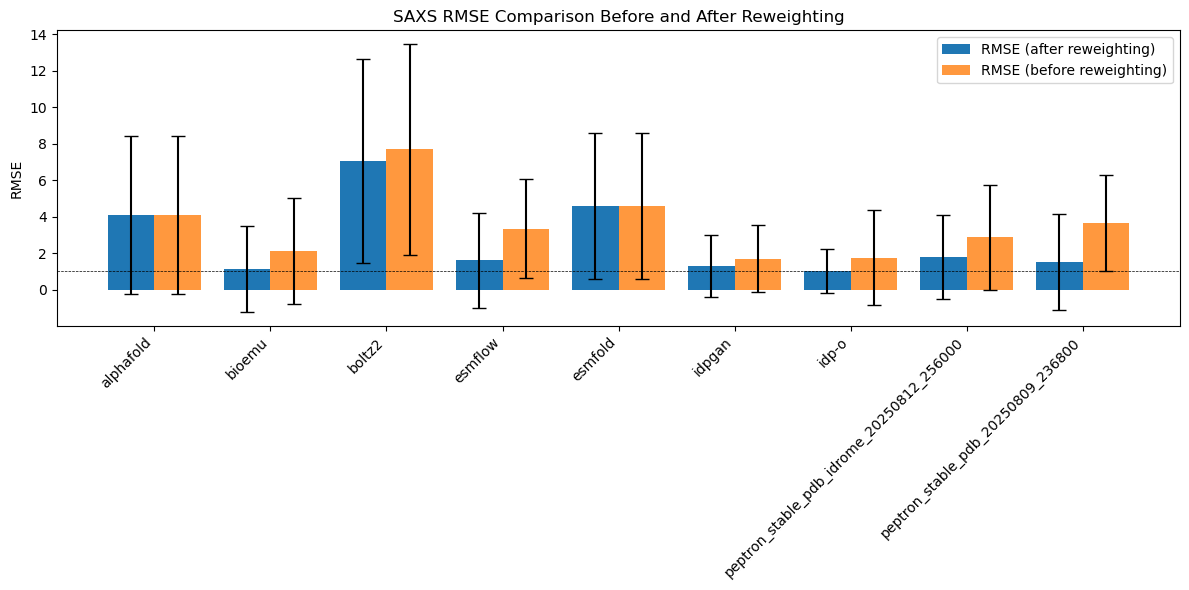

In [5]:
# Create bar positions
x = np.arange(len(df["Model"]))  # the label locations
width = 0.4  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Bars
rects1 = ax.bar(x - width/2, df["RMSE median"], width, yerr=df["RMSE sd"], capsize=5, label="RMSE (after reweighting)")
rects2 = ax.bar(x + width/2, df["RMSE median no rew."], width, yerr=df["RMSE no rew. sd"], capsize=5, label="RMSE (before reweighting)", alpha=0.8)

# Labels and formatting
ax.set_ylabel("RMSE")
ax.set_title(f"SAXS RMSE Comparison Before and After Reweighting")
ax.set_xticks(x)
ax.set_xticklabels(df["Model"], rotation=45, ha="right")
ax.legend()
ax.axhline(1,color = 'black',linestyle= 'dashed', linewidth=0.5)

plt.tight_layout()
#plt.savefig(output_path+'SAXS_RMSE_models.png', dpi=300)

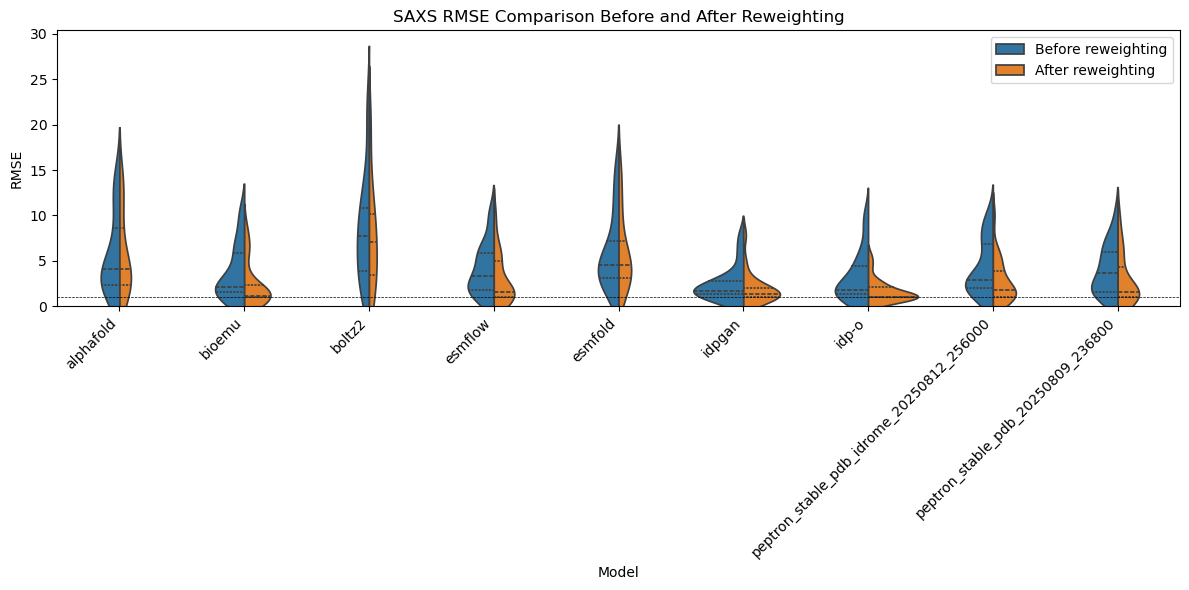

In [6]:
# violin plot

df_list = []

# Before reweighting
for model, vals in allvalues_prior.items():
    df_list.append(pd.DataFrame({
        "Model": model,
        "Condition": "Before reweighting",
        "RMSE": vals
    }))

# After reweighting
for model, vals in allvalues.items():
    df_list.append(pd.DataFrame({
        "Model": model,
        "Condition": "After reweighting",
        "RMSE": vals
    }))

# Combine into long DataFrame
df_long = pd.concat(df_list, ignore_index=True)

# Plot violin plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(
    data=df_long,
    x="Model",
    y="RMSE",
    hue="Condition",
    split=True,        # both distributions in one violin per model
    inner="quartile",  # show median and quartiles
    ax=ax
)

# Formatting
ax.set_ylabel("RMSE")
ax.set_title(f"SAXS RMSE Comparison Before and After Reweighting")
ax.axhline(1, color="black", linestyle="dashed", linewidth=0.5)
ax.legend(title="")
ax.set_ylim(0,)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
#plt.savefig(output_path+"SAXS_RMSE_violin.png", dpi=300)

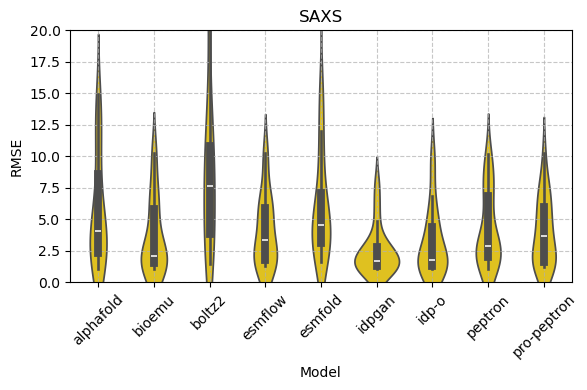

In [ ]:
# prior only only

models = ['alphafold', 'bioemu',  'boltz2',  'esmflow',  'esmfold',  'idpgan',  'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800'] 


statsdict = {}

for model in models:

    saxs_rmse = []
    for ele in allvalues_prior[model]:
        
        saxs_rmse.append(ele)
    
    statsdict[model] = {}
    statsdict[model]['SAXS RMSE'] = saxs_rmse

# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for cs in vals['SAXS RMSE']:
        data.append({"Model": model, "Metric": "SAXS RMSE", "Value": cs})

df = pd.DataFrame(data)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "peptron"}
)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_20250809_236800": "peptron-base"}
)

fig, ax = plt.subplots(figsize=(6, 4))


# Violin plot for SAXS RMSE
sns.violinplot(data=df[df["Metric"]=="SAXS RMSE"], 
               x="Model", y="Value", inner="box", color="gold")
ax.set_title("SAXS")
ax.set_ylabel("RMSE")
ax.tick_params(axis='x', rotation=45)
ax.grid(True, which='major', linestyle='--', alpha=0.7)
ax.set_ylim(0,20)

plt.tight_layout()
#plt.savefig(output_path+f"all_SAXS_prior.png")


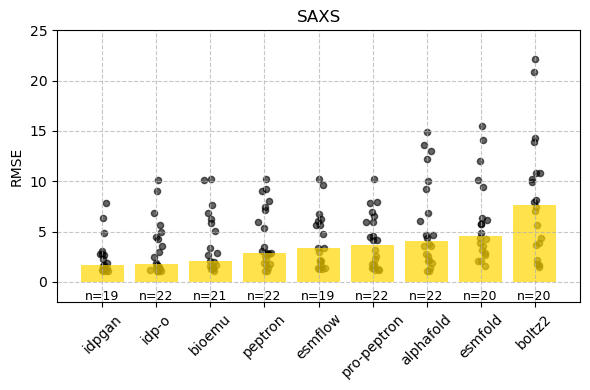

In [ ]:
# Convert statsdict into a dataframe
# prior only only

models = ['alphafold', 'bioemu',  'boltz2',  'esmflow',  'esmfold',  'idpgan',  'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800'] 


statsdict = {}

for model in models:

    saxs_rmse = []
    for ele in allvalues_prior[model]:
        
        saxs_rmse.append(ele)
    
    statsdict[model] = {}
    statsdict[model]['SAXS RMSE'] = saxs_rmse

# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for cs in vals['SAXS RMSE']:
        data.append({"Model": model, "Metric": "SAXS RMSE", "Value": cs})

df = pd.DataFrame(data)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "peptron"}
)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_20250809_236800": "peptron-base"}
)

# Compute medians & counts and sort by median (ascending)
summary = df.groupby("Model")["Value"].agg(["median", "count"]).reset_index()
summary = summary.sort_values("median", ascending=True).reset_index(drop=True)

# Ensure df follows the same model order
df["Model"] = pd.Categorical(df["Model"], categories=summary["Model"], ordered=True)

fig, ax = plt.subplots(figsize=(6, 4))

# Bar plot for medians
bars = ax.bar(summary["Model"], summary["median"], color="gold", alpha=0.7)

# Scatter plot of individual data points with jitter
for i, model in enumerate(summary["Model"]):
    vals = df[df["Model"] == model]["Value"]
    # jitter around the x-position
    np.random.seed(0)
    x_jittered = np.random.normal(loc=i, scale=0.05, size=len(vals))
    ax.scatter(x_jittered, vals, color="black", alpha=0.6, s=20)

# Annotate counts BELOW the x-ticks
for i, row in summary.iterrows():
    ax.text(i, -0.8, f"n={row['count']}",
            ha="center", va="top", fontsize=9)

ax.set_title("SAXS")
ax.set_ylabel("RMSE")
ax.tick_params(axis='x', rotation=45)
ax.grid(True, which='major', linestyle='--', alpha=0.7)
ax.set_ylim(-2, 25)  # extend lower bound so n= fits under bars

plt.tight_layout()
#plt.savefig(output_path + "all_SAXS_prior.png")


Number of common proteins: 18


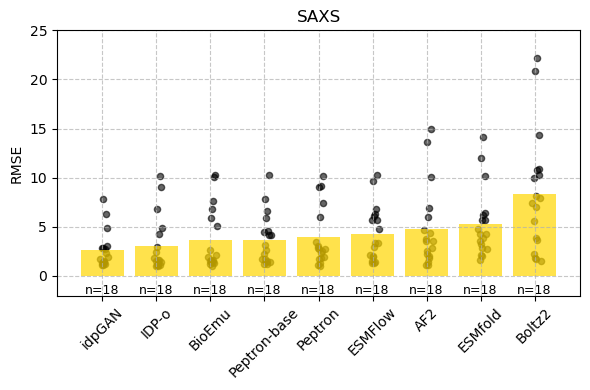

In [27]:
# --- Step 1: get common proteins across all models (only if data exists in SAXSdict[model][protein]) ---
common_proteins = set.intersection(
    *[set([prot for prot, vals in SAXSdict[model].items() if len(vals) > 0])
      for model in models]
)

print(f"Number of common proteins: {len(common_proteins)}")

# --- Step 2: build long dataframe (before/after reweighting) ---
df_list = []

for model in models:
    for protein in common_proteins:
        if len(SAXSdict[model][protein]) == 0:  # skip if missing
            continue
        df_list.append({
            "Model": model,
            "Condition": "Before reweighting",
            "Protein": protein,
            "RMSE": SAXSdict[model][protein]['Prior RMSE']
        })
        

df_long = pd.DataFrame(df_list)

# --- Step 3: clean model names ---
df_long["Model"] = df_long["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "Peptron",
     "peptron_stable_pdb_20250809_236800": "Peptron-base",
     "idp-o": "IDP-o",
     "boltz2": "Boltz2",
     "alphafold": "AF2",
     "esmfold": "ESMfold",
     "idpgan": "idpGAN",
     "bioemu": "BioEmu",
     "esmflow": "ESMFlow"}
)

# --- Step 4: compute summary stats ---
summary = df_long.groupby(["Model", "Condition"])["RMSE"].agg(["mean", "count"]).reset_index()

# --- Step 5: plot example (Before reweighting only, sorted by mean) ---
summary_before = summary[summary["Condition"] == "Before reweighting"].sort_values("mean")

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(summary_before["Model"], summary_before["mean"], color="gold", alpha=0.7)

# scatter with jitter
for i, model in enumerate(summary_before["Model"]):
    vals = df_long[(df_long["Model"] == model) & (df_long["Condition"] == "Before reweighting")]["RMSE"].values
    np.random.seed(0)
    x_jittered = np.random.normal(loc=i, scale=0.05, size=len(vals))
    ax.scatter(x_jittered, vals, color="black", alpha=0.6, s=20)

# annotate counts
for i, row in summary_before.iterrows():
    ax.text(i, -0.8, f"n={row['count']}", ha="center", va="top", fontsize=9)

ax.set_title("SAXS")
ax.set_ylabel("RMSE")
ax.tick_params(axis='x', rotation=45)
ax.grid(True, which='major', linestyle='--', alpha=0.7)
ax.set_ylim(-2, 25)

plt.tight_layout()
plt.savefig(output_path + "final_ranked_SAXS_prior_common_proteins_mean.png")


Number of common proteins: 18


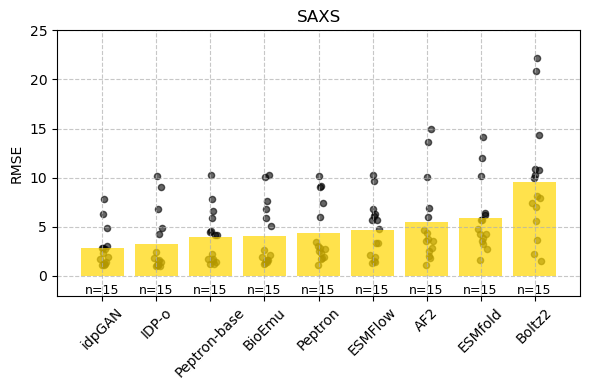

In [28]:
# --- Step 1: get common proteins across all models (only if data exists in SAXSdict[model][protein]) ---
common_proteins = set.intersection(
    *[set([prot for prot, vals in SAXSdict[model].items() if len(vals) > 0])
      for model in models]
)

print(f"Number of common proteins: {len(common_proteins)}")

# --- Step 2: build long dataframe (before/after reweighting) ---
df_list = []

for model in models:
    for protein in common_proteins:
        # check if CS reweighting around
        if not os.path.exists(f"../protonated_predictions/{model}/{protein}/CSrew_UCBshift.npy"):
            continue
        if len(SAXSdict[model][protein]) == 0:  # skip if missing
            continue
        df_list.append({
            "Model": model,
            "Condition": "Before reweighting",
            "Protein": protein,
            "RMSE": SAXSdict[model][protein]['Prior RMSE']
        })
        

df_long = pd.DataFrame(df_list)

# --- Step 3: clean model names ---
df_long["Model"] = df_long["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "Peptron",
     "peptron_stable_pdb_20250809_236800": "Peptron-base",
     "idp-o": "IDP-o",
     "boltz2": "Boltz2",
     "alphafold": "AF2",
     "esmfold": "ESMfold",
     "idpgan": "idpGAN",
     "bioemu": "BioEmu",
     "esmflow": "ESMFlow"}
)

# --- Step 4: compute summary stats ---
summary = df_long.groupby(["Model", "Condition"])["RMSE"].agg(["mean", "count"]).reset_index()

# --- Step 5: plot example (Before reweighting only, sorted by mean) ---
summary_before = summary[summary["Condition"] == "Before reweighting"].sort_values("mean")

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(summary_before["Model"], summary_before["mean"], color="gold", alpha=0.7)

# scatter with jitter
for i, model in enumerate(summary_before["Model"]):
    vals = df_long[(df_long["Model"] == model) & (df_long["Condition"] == "Before reweighting")]["RMSE"].values
    np.random.seed(0)
    x_jittered = np.random.normal(loc=i, scale=0.05, size=len(vals))
    ax.scatter(x_jittered, vals, color="black", alpha=0.6, s=20)

# annotate counts
for i, row in summary_before.iterrows():
    ax.text(i, -0.8, f"n={row['count']}", ha="center", va="top", fontsize=9)

ax.set_title("SAXS")
ax.set_ylabel("RMSE")
ax.tick_params(axis='x', rotation=45)
ax.grid(True, which='major', linestyle='--', alpha=0.7)
ax.set_ylim(-2, 25)

plt.tight_layout()
plt.savefig(output_path + "final_ranked_SAXS_prior_common_proteins_mean_CSintersection.png")


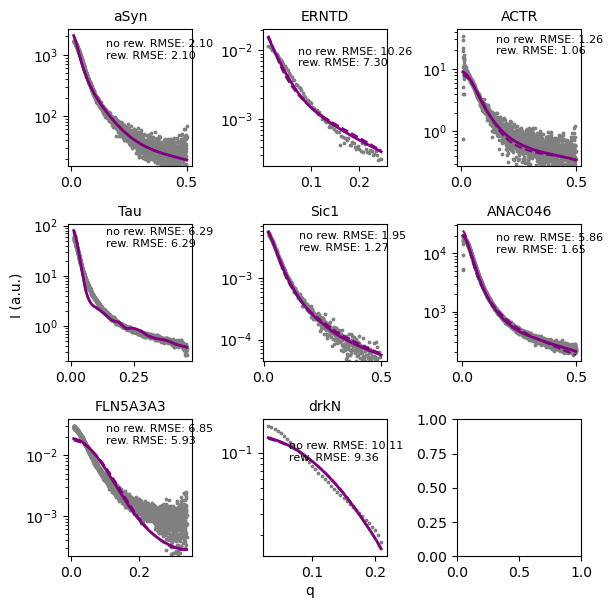

In [ ]:
# plot SAXS experimental vs generated curves - exp vs calc (for every model separately as a plot and each protein per plot)
### MAKE SURE THE PRE CROSS CORRELATION ANLAYSIS (analyse_IntegrativeDB_PRE.ipynb) HAS RUN BEFORE THIS CELL

model = 'bioemu'
yaxis= 'log'

# load cross-correlation data
predict = np.load('PRE_analyses/PRE_SAXSrew_corr_analysis_dict.npy',allow_pickle=True).item()
PROTEINS = list(predict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*0.75,len(PROTEINS)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy'):
        continue
    saxsrew = np.load(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy',allow_pickle=True).item()
    try:
        len(list(saxsrew.keys()))
    except:
        print(f'Empty array: {model}/{prot}')
        continue

    # optimal posterior ensembles
    IDX = predict[model][prot]['Final Post IDX']

    # load data
    predfile = f'../processed_predictions/{model}/pepsisaxs_{prot}/saxs_curves.csv'
    expfile = f'../EXP_DATA/{prot}/SAXS_bift.dat'
    ensemble_path = f'../processed_predictions/{model}/'
    exp = parse_saxs_dat(expfile)
    q, I_gen = parse_gensaxs_dat(predfile)
    I_exp = np.array(exp['I(q)'])
    sigma_exp = np.array(exp['sigma'])
    s = get_intensity_scaling(I_exp, sigma_exp, I_gen)
    weights_nan = saxsrew['weights']
    wopt = np.nan_to_num(saxsrew['all_weights'][IDX], nan=0)

    #plt.errorbar(q, I_exp, sigma_exp, color = 'grey')
    ax.scatter(q, I_exp, color = 'grey',s=3)
    ax.plot(q, np.average(I_gen, axis=0, weights=wopt), color = 'purple', linewidth=2)
    ax.plot(q, np.average(I_gen[~np.isnan(weights_nan), :], axis=0), color = 'purple',linestyle='dashed') # unphysical conformations removed (nan weights)

    text_string = str("no rew. RMSE: {:.2f}\n".format(saxsrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(saxsrew['all_post_rmse'][IDX]))
    ax.text(0.3*np.max(q), np.max(I_exp)*0.5, text_string, fontsize=8)

    if yaxis=='log':
        ax.set_yscale('log')

# Set one master x and y label
fig.text(0.5, -0.00, 'q', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'I (a.u.)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SAXScurves_{model}_exp_vs_calc.png', dpi=200)



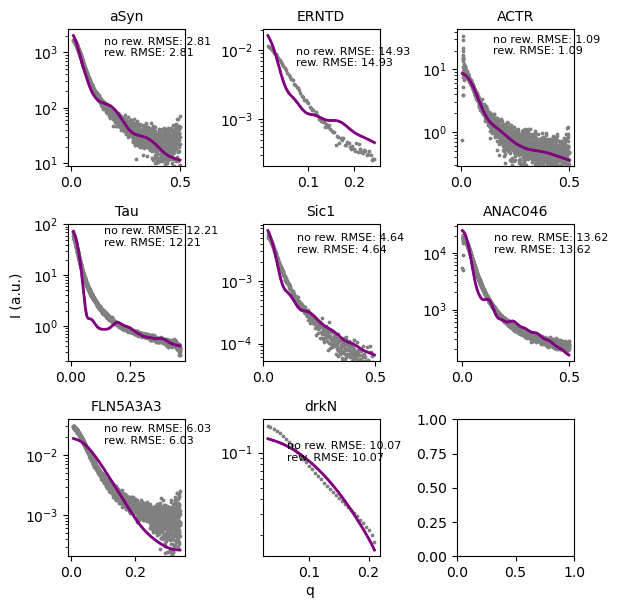

In [12]:
# plot SAXS experimental vs generated curves - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'alphafold'
yaxis= 'log'

# load cross-correlation data
predict = np.load('PRE_analyses/PRE_SAXSrew_corr_analysis_dict.npy',allow_pickle=True).item()
PROTEINS = list(predict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*0.75,len(PROTEINS)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy'):
        continue
    saxsrew = np.load(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy',allow_pickle=True).item()
    try:
        len(list(saxsrew.keys()))
    except:
        print(f'Empty array: {model}/{prot}')
        continue

    # optimal posterior ensembles
    IDX = predict[model][prot]['Final Post IDX']

    # load data
    predfile = f'../processed_predictions/{model}/pepsisaxs_{prot}/saxs_curves.csv'
    expfile = f'../EXP_DATA/{prot}/SAXS_bift.dat'
    ensemble_path = f'../processed_predictions/{model}/'
    exp = parse_saxs_dat(expfile)
    q, I_gen = parse_gensaxs_dat(predfile)
    I_exp = np.array(exp['I(q)'])
    sigma_exp = np.array(exp['sigma'])
    s = get_intensity_scaling(I_exp, sigma_exp, I_gen)
    weights_nan = saxsrew['weights']
    wopt = np.nan_to_num(saxsrew['all_weights'][IDX], nan=0)

    #plt.errorbar(q, I_exp, sigma_exp, color = 'grey')
    ax.scatter(q, I_exp, color = 'grey',s=3)
    ax.plot(q, np.average(I_gen, axis=0, weights=wopt), color = 'purple', linewidth=2)
    ax.plot(q, np.average(I_gen[~np.isnan(weights_nan), :], axis=0), color = 'purple',linestyle='dashed') # unphysical conformations removed (nan weights)

    text_string = str("no rew. RMSE: {:.2f}\n".format(saxsrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(saxsrew['all_post_rmse'][IDX]))
    ax.text(0.3*np.max(q), np.max(I_exp)*0.5, text_string, fontsize=8)

    if yaxis=='log':
        ax.set_yscale('log')

# Set one master x and y label
fig.text(0.5, -0.00, 'q', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'I (a.u.)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SAXScurves_{model}_exp_vs_calc.png', dpi=200)



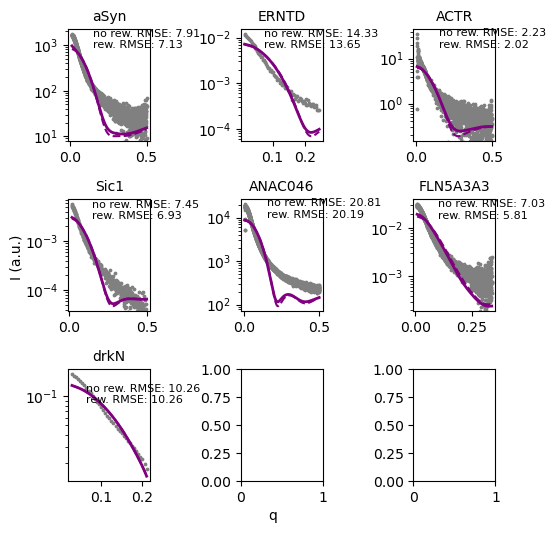

In [13]:
# plot SAXS experimental vs generated curves - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'boltz2'
yaxis= 'log'

# load cross-correlation data
predict = np.load('PRE_analyses/PRE_SAXSrew_corr_analysis_dict.npy',allow_pickle=True).item()
PROTEINS = list(predict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*0.75,len(PROTEINS)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy'):
        continue
    saxsrew = np.load(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy',allow_pickle=True).item()
    try:
        len(list(saxsrew.keys()))
    except:
        print(f'Empty array: {model}/{prot}')
        continue

    # optimal posterior ensembles
    IDX = predict[model][prot]['Final Post IDX']

    # load data
    predfile = f'../processed_predictions/{model}/pepsisaxs_{prot}/saxs_curves.csv'
    expfile = f'../EXP_DATA/{prot}/SAXS_bift.dat'
    ensemble_path = f'../processed_predictions/{model}/'
    exp = parse_saxs_dat(expfile)
    q, I_gen = parse_gensaxs_dat(predfile)
    I_exp = np.array(exp['I(q)'])
    sigma_exp = np.array(exp['sigma'])
    s = get_intensity_scaling(I_exp, sigma_exp, I_gen)
    weights_nan = saxsrew['weights']
    wopt = np.nan_to_num(saxsrew['all_weights'][IDX], nan=0)

    #plt.errorbar(q, I_exp, sigma_exp, color = 'grey')
    ax.scatter(q, I_exp, color = 'grey',s=3)
    ax.plot(q, np.average(I_gen, axis=0, weights=wopt), color = 'purple', linewidth=2)
    ax.plot(q, np.average(I_gen[~np.isnan(weights_nan), :], axis=0), color = 'purple',linestyle='dashed') # unphysical conformations removed (nan weights)

    text_string = str("no rew. RMSE: {:.2f}\n".format(saxsrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(saxsrew['all_post_rmse'][IDX]))
    ax.text(0.3*np.max(q), np.max(I_exp)*0.5, text_string, fontsize=8)

    if yaxis=='log':
        ax.set_yscale('log')

# Set one master x and y label
fig.text(0.5, -0.00, 'q', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'I (a.u.)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SAXScurves_{model}_exp_vs_calc.png', dpi=200)



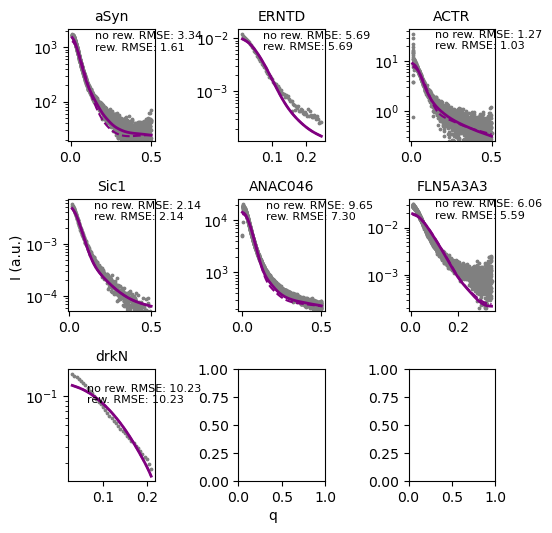

In [14]:
# plot SAXS experimental vs generated curves - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'esmflow'
yaxis= 'log'

# load cross-correlation data
predict = np.load('PRE_analyses/PRE_SAXSrew_corr_analysis_dict.npy',allow_pickle=True).item()
PROTEINS = list(predict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*0.75,len(PROTEINS)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy'):
        continue
    saxsrew = np.load(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy',allow_pickle=True).item()
    try:
        len(list(saxsrew.keys()))
    except:
        print(f'Empty array: {model}/{prot}')
        continue

    # optimal posterior ensembles
    IDX = predict[model][prot]['Final Post IDX']

    # load data
    predfile = f'../processed_predictions/{model}/pepsisaxs_{prot}/saxs_curves.csv'
    expfile = f'../EXP_DATA/{prot}/SAXS_bift.dat'
    ensemble_path = f'../processed_predictions/{model}/'
    exp = parse_saxs_dat(expfile)
    q, I_gen = parse_gensaxs_dat(predfile)
    I_exp = np.array(exp['I(q)'])
    sigma_exp = np.array(exp['sigma'])
    s = get_intensity_scaling(I_exp, sigma_exp, I_gen)
    weights_nan = saxsrew['weights']
    wopt = np.nan_to_num(saxsrew['all_weights'][IDX], nan=0)

    #plt.errorbar(q, I_exp, sigma_exp, color = 'grey')
    ax.scatter(q, I_exp, color = 'grey',s=3)
    ax.plot(q, np.average(I_gen, axis=0, weights=wopt), color = 'purple', linewidth=2)
    ax.plot(q, np.average(I_gen[~np.isnan(weights_nan), :], axis=0), color = 'purple',linestyle='dashed') # unphysical conformations removed (nan weights)

    text_string = str("no rew. RMSE: {:.2f}\n".format(saxsrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(saxsrew['all_post_rmse'][IDX]))
    ax.text(0.3*np.max(q), np.max(I_exp)*0.5, text_string, fontsize=8)

    if yaxis=='log':
        ax.set_yscale('log')

# Set one master x and y label
fig.text(0.5, -0.00, 'q', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'I (a.u.)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SAXScurves_{model}_exp_vs_calc.png', dpi=200)



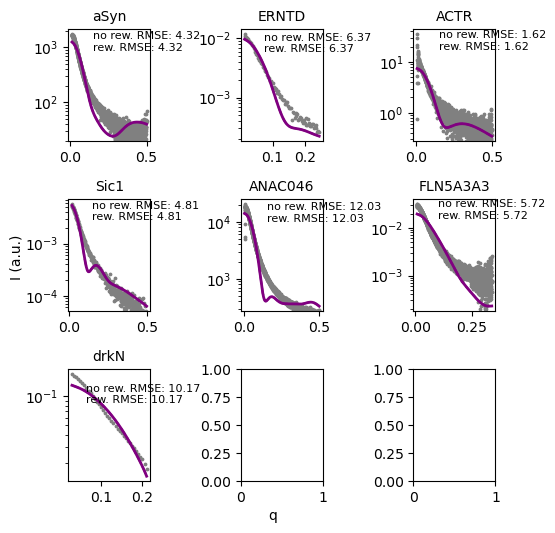

In [15]:
# plot SAXS experimental vs generated curves - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'esmfold'
yaxis= 'log'

# load cross-correlation data
predict = np.load('PRE_analyses/PRE_SAXSrew_corr_analysis_dict.npy',allow_pickle=True).item()
PROTEINS = list(predict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*0.75,len(PROTEINS)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy'):
        continue
    saxsrew = np.load(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy',allow_pickle=True).item()
    try:
        len(list(saxsrew.keys()))
    except:
        print(f'Empty array: {model}/{prot}')
        continue

    # optimal posterior ensembles
    IDX = predict[model][prot]['Final Post IDX']

    # load data
    predfile = f'../processed_predictions/{model}/pepsisaxs_{prot}/saxs_curves.csv'
    expfile = f'../EXP_DATA/{prot}/SAXS_bift.dat'
    ensemble_path = f'../processed_predictions/{model}/'
    exp = parse_saxs_dat(expfile)
    q, I_gen = parse_gensaxs_dat(predfile)
    I_exp = np.array(exp['I(q)'])
    sigma_exp = np.array(exp['sigma'])
    s = get_intensity_scaling(I_exp, sigma_exp, I_gen)
    weights_nan = saxsrew['weights']
    wopt = np.nan_to_num(saxsrew['all_weights'][IDX], nan=0)

    #plt.errorbar(q, I_exp, sigma_exp, color = 'grey')
    ax.scatter(q, I_exp, color = 'grey',s=3)
    ax.plot(q, np.average(I_gen, axis=0, weights=wopt), color = 'purple', linewidth=2)
    ax.plot(q, np.average(I_gen[~np.isnan(weights_nan), :], axis=0), color = 'purple',linestyle='dashed') # unphysical conformations removed (nan weights)

    text_string = str("no rew. RMSE: {:.2f}\n".format(saxsrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(saxsrew['all_post_rmse'][IDX]))
    ax.text(0.3*np.max(q), np.max(I_exp)*0.5, text_string, fontsize=8)

    if yaxis=='log':
        ax.set_yscale('log')

# Set one master x and y label
fig.text(0.5, -0.00, 'q', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'I (a.u.)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SAXScurves_{model}_exp_vs_calc.png', dpi=200)



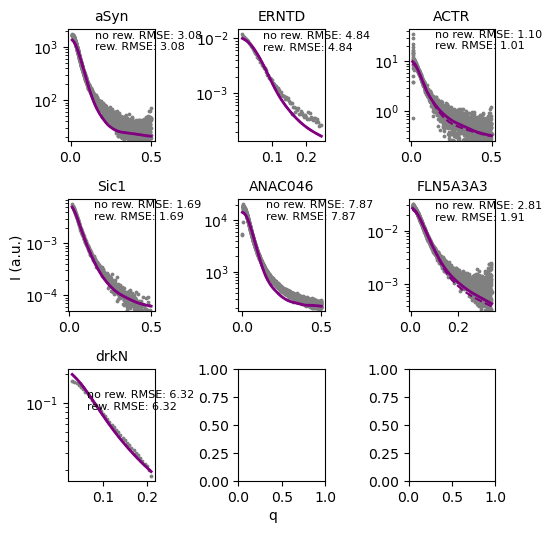

In [16]:
# plot SAXS experimental vs generated curves - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'idpgan'
yaxis= 'log'

# load cross-correlation data
predict = np.load('PRE_analyses/PRE_SAXSrew_corr_analysis_dict.npy',allow_pickle=True).item()
PROTEINS = list(predict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*0.75,len(PROTEINS)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy'):
        continue
    saxsrew = np.load(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy',allow_pickle=True).item()
    try:
        len(list(saxsrew.keys()))
    except:
        print(f'Empty array: {model}/{prot}')
        continue

    # optimal posterior ensembles
    IDX = predict[model][prot]['Final Post IDX']

    # load data
    predfile = f'../processed_predictions/{model}/pepsisaxs_{prot}/saxs_curves.csv'
    expfile = f'../EXP_DATA/{prot}/SAXS_bift.dat'
    ensemble_path = f'../processed_predictions/{model}/'
    exp = parse_saxs_dat(expfile)
    q, I_gen = parse_gensaxs_dat(predfile)
    I_exp = np.array(exp['I(q)'])
    sigma_exp = np.array(exp['sigma'])
    s = get_intensity_scaling(I_exp, sigma_exp, I_gen)
    weights_nan = saxsrew['weights']
    wopt = np.nan_to_num(saxsrew['all_weights'][IDX], nan=0)

    #plt.errorbar(q, I_exp, sigma_exp, color = 'grey')
    ax.scatter(q, I_exp, color = 'grey',s=3)
    ax.plot(q, np.average(I_gen, axis=0, weights=wopt), color = 'purple', linewidth=2)
    ax.plot(q, np.average(I_gen[~np.isnan(weights_nan), :], axis=0), color = 'purple',linestyle='dashed') # unphysical conformations removed (nan weights)

    text_string = str("no rew. RMSE: {:.2f}\n".format(saxsrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(saxsrew['all_post_rmse'][IDX]))
    ax.text(0.3*np.max(q), np.max(I_exp)*0.5, text_string, fontsize=8)

    if yaxis=='log':
        ax.set_yscale('log')

# Set one master x and y label
fig.text(0.5, -0.00, 'q', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'I (a.u.)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SAXScurves_{model}_exp_vs_calc.png', dpi=200)



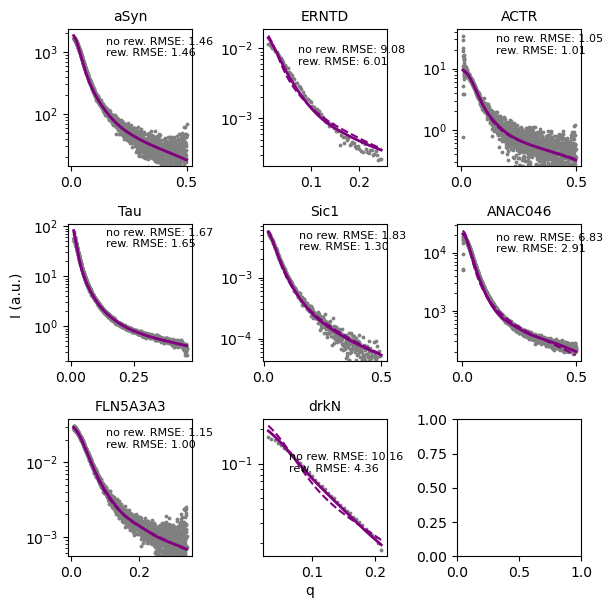

In [17]:
# plot SAXS experimental vs generated curves - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'idp-o'
yaxis= 'log'

# load cross-correlation data
predict = np.load('PRE_analyses/PRE_SAXSrew_corr_analysis_dict.npy',allow_pickle=True).item()
PROTEINS = list(predict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*0.75,len(PROTEINS)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy'):
        continue
    saxsrew = np.load(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy',allow_pickle=True).item()
    try:
        len(list(saxsrew.keys()))
    except:
        print(f'Empty array: {model}/{prot}')
        continue

    # optimal posterior ensembles
    IDX = predict[model][prot]['Final Post IDX']

    # load data
    predfile = f'../processed_predictions/{model}/pepsisaxs_{prot}/saxs_curves.csv'
    expfile = f'../EXP_DATA/{prot}/SAXS_bift.dat'
    ensemble_path = f'../processed_predictions/{model}/'
    exp = parse_saxs_dat(expfile)
    q, I_gen = parse_gensaxs_dat(predfile)
    I_exp = np.array(exp['I(q)'])
    sigma_exp = np.array(exp['sigma'])
    s = get_intensity_scaling(I_exp, sigma_exp, I_gen)
    weights_nan = saxsrew['weights']
    wopt = np.nan_to_num(saxsrew['all_weights'][IDX], nan=0)

    #plt.errorbar(q, I_exp, sigma_exp, color = 'grey')
    ax.scatter(q, I_exp, color = 'grey',s=3)
    ax.plot(q, np.average(I_gen, axis=0, weights=wopt), color = 'purple', linewidth=2)
    ax.plot(q, np.average(I_gen[~np.isnan(weights_nan), :], axis=0), color = 'purple',linestyle='dashed') # unphysical conformations removed (nan weights)

    text_string = str("no rew. RMSE: {:.2f}\n".format(saxsrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(saxsrew['all_post_rmse'][IDX]))
    ax.text(0.3*np.max(q), np.max(I_exp)*0.5, text_string, fontsize=8)

    if yaxis=='log':
        ax.set_yscale('log')

# Set one master x and y label
fig.text(0.5, -0.00, 'q', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'I (a.u.)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SAXScurves_{model}_exp_vs_calc.png', dpi=200)



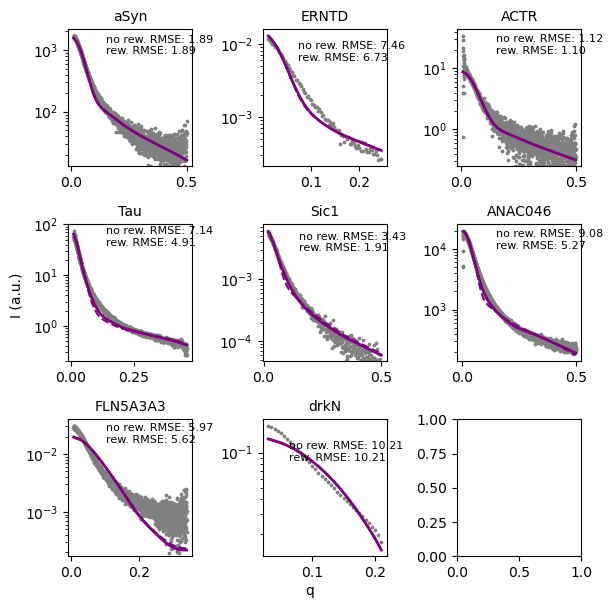

In [18]:
# plot SAXS experimental vs generated curves - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'peptron_stable_pdb_idrome_20250812_256000'
yaxis= 'log'

# load cross-correlation data
predict = np.load('PRE_analyses/PRE_SAXSrew_corr_analysis_dict.npy',allow_pickle=True).item()
PROTEINS = list(predict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*0.75,len(PROTEINS)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy'):
        continue
    saxsrew = np.load(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy',allow_pickle=True).item()
    try:
        len(list(saxsrew.keys()))
    except:
        print(f'Empty array: {model}/{prot}')
        continue

    # optimal posterior ensembles
    IDX = predict[model][prot]['Final Post IDX']

    # load data
    predfile = f'../processed_predictions/{model}/pepsisaxs_{prot}/saxs_curves.csv'
    expfile = f'../EXP_DATA/{prot}/SAXS_bift.dat'
    ensemble_path = f'../processed_predictions/{model}/'
    exp = parse_saxs_dat(expfile)
    q, I_gen = parse_gensaxs_dat(predfile)
    I_exp = np.array(exp['I(q)'])
    sigma_exp = np.array(exp['sigma'])
    s = get_intensity_scaling(I_exp, sigma_exp, I_gen)
    weights_nan = saxsrew['weights']
    wopt = np.nan_to_num(saxsrew['all_weights'][IDX], nan=0)

    #plt.errorbar(q, I_exp, sigma_exp, color = 'grey')
    ax.scatter(q, I_exp, color = 'grey',s=3)
    ax.plot(q, np.average(I_gen, axis=0, weights=wopt), color = 'purple', linewidth=2)
    ax.plot(q, np.average(I_gen[~np.isnan(weights_nan), :], axis=0), color = 'purple',linestyle='dashed') # unphysical conformations removed (nan weights)

    text_string = str("no rew. RMSE: {:.2f}\n".format(saxsrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(saxsrew['all_post_rmse'][IDX]))
    ax.text(0.3*np.max(q), np.max(I_exp)*0.5, text_string, fontsize=8)

    if yaxis=='log':
        ax.set_yscale('log')

# Set one master x and y label
fig.text(0.5, -0.00, 'q', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'I (a.u.)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SAXScurves_{model}_exp_vs_calc.png', dpi=200)



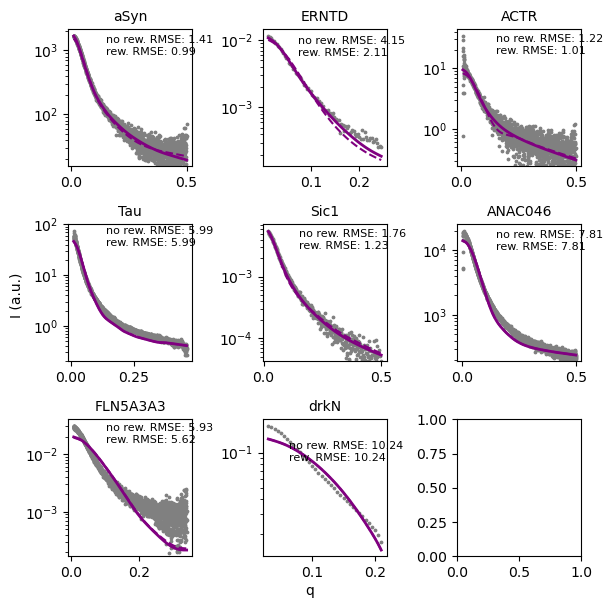

In [19]:
# plot SAXS experimental vs generated curves - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'peptron_stable_pdb_20250809_236800'
yaxis= 'log'

# load cross-correlation data
predict = np.load('PRE_analyses/PRE_SAXSrew_corr_analysis_dict.npy',allow_pickle=True).item()
PROTEINS = list(predict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*0.75,len(PROTEINS)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy'):
        continue
    saxsrew = np.load(f'../protonated_predictions/{model}/{prot}/SAXSrew.npy',allow_pickle=True).item()
    try:
        len(list(saxsrew.keys()))
    except:
        print(f'Empty array: {model}/{prot}')
        continue

    # optimal posterior ensembles
    IDX = predict[model][prot]['Final Post IDX']

    # load data
    predfile = f'../processed_predictions/{model}/pepsisaxs_{prot}/saxs_curves.csv'
    expfile = f'../EXP_DATA/{prot}/SAXS_bift.dat'
    ensemble_path = f'../processed_predictions/{model}/'
    exp = parse_saxs_dat(expfile)
    q, I_gen = parse_gensaxs_dat(predfile)
    I_exp = np.array(exp['I(q)'])
    sigma_exp = np.array(exp['sigma'])
    s = get_intensity_scaling(I_exp, sigma_exp, I_gen)
    weights_nan = saxsrew['weights']
    wopt = np.nan_to_num(saxsrew['all_weights'][IDX], nan=0)

    #plt.errorbar(q, I_exp, sigma_exp, color = 'grey')
    ax.scatter(q, I_exp, color = 'grey',s=3)
    ax.plot(q, np.average(I_gen, axis=0, weights=wopt), color = 'purple', linewidth=2)
    ax.plot(q, np.average(I_gen[~np.isnan(weights_nan), :], axis=0), color = 'purple',linestyle='dashed') # unphysical conformations removed (nan weights)

    text_string = str("no rew. RMSE: {:.2f}\n".format(saxsrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(saxsrew['all_post_rmse'][IDX]))
    ax.text(0.3*np.max(q), np.max(I_exp)*0.5, text_string, fontsize=8)

    if yaxis=='log':
        ax.set_yscale('log')

# Set one master x and y label
fig.text(0.5, -0.00, 'q', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'I (a.u.)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SAXScurves_{model}_exp_vs_calc.png', dpi=200)

